# Comparing model performance with a simple baseline

In this notebook, we present how to compare the generalization performance of
a model to a minimal baseline. In regression, we can use the `DummyRegressor`
class to predict the mean target value observed on the training set without
using the input features.

We now demonstrate how to compute the score of a regression model and then
compare it to such a baseline on the California housing dataset.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
section named "Appendix - Datasets description" at the end of this MOOC.</p>
</div>

In [1]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

Across all evaluations, we will use a `ShuffleSplit` cross-validation splitter
with 20% of the data held on the validation side of the split.

In [2]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)

We start by running the cross-validation for a simple decision tree regressor
which is our model of interest. Besides, we will store the testing error in a
pandas series to make it easier to plot the results.

In [3]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

regressor = DecisionTreeRegressor()
cv_results_tree_regressor = cross_validate(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error", n_jobs=2
)

errors_tree_regressor = pd.Series(
    -cv_results_tree_regressor["test_score"], name="Decision tree regressor"
)
errors_tree_regressor.describe()

count    30.000000
mean     45.708839
std       1.248683
min      43.218667
25%      44.875690
50%      45.832373
75%      46.592504
max      47.888003
Name: Decision tree regressor, dtype: float64

Then, we evaluate our baseline. This baseline is called a dummy regressor.
This dummy regressor will always predict the mean target computed on the
training target variable. Therefore, the dummy regressor does not use any
information from the input features stored in the dataframe named `data`.

In [4]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
result_dummy = cross_validate(
    dummy, data, target, cv=cv, scoring="neg_mean_absolute_error", n_jobs=2
)
errors_dummy_regressor = pd.Series(
    -result_dummy["test_score"], name="Dummy regressor"
)
errors_dummy_regressor.describe()

count    30.000000
mean     91.140009
std       0.821140
min      89.757566
25%      90.543652
50%      91.034555
75%      91.979007
max      92.477244
Name: Dummy regressor, dtype: float64

We now plot the cross-validation testing errors for the mean target baseline
and the actual decision tree regressor.

In [5]:
all_errors = pd.concat(
    [errors_tree_regressor, errors_dummy_regressor],
    axis=1,
)
all_errors

,Decision tree regressor,Dummy regressor
0,47.032650,90.713153
1,46.612182,90.539353
2,44.317411,91.941912
3,43.218667,90.213912
4,47.888003,92.015862
5,44.737104,90.542490
6,43.544951,89.757566
7,44.856680,92.477244
8,45.392505,90.947952
9,44.515251,91.991373


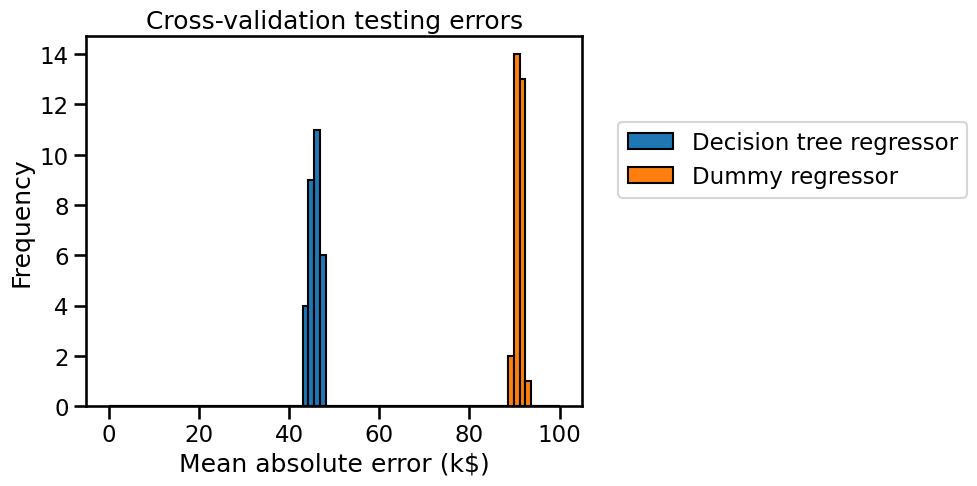

In [6]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.linspace(start=0, stop=100, num=80)
all_errors.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Cross-validation testing errors")

We see that the generalization performance of our decision tree is far from
being perfect: the price predictions are off by more than 45,000 US dollars on
average. However it is much better than the mean price baseline. So this
confirms that it is possible to predict the housing price much better by using
a model that takes into account the values of the input features (housing
location, size, neighborhood income...). Such a model makes more informed
predictions and approximately divides the error rate by a factor of 2 compared
to the baseline that ignores the input features.

Note that here we used the mean price as the baseline prediction. We could
have used the median instead. See the online documentation of the
[sklearn.dummy.DummyRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html)
class for other options. For this particular example, using the mean instead
of the median does not make much of a difference but this could have been the
case for dataset with extreme outliers.